# General imports

In [1]:
import pandas as pd
import numpy as np
import torch
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install transformers
!pip install sentencepiece
!pip install rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=6939d196ed91821cc7f5ca455407886c5de37b4ce31552271c32927b3e29af59
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


# Connect to drive to access models and data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
ROOT = "/content/drive/MyDrive/Colab Notebooks/NLP project/"

# Generate training and testing datasets

In [5]:
training = pd.read_csv(ROOT+'train_cut.csv', encoding='utf-8')
testing = pd.read_csv(ROOT+'test_cut.csv', encoding='utf-8')

# Add keyword "summarize" to each instance original text
training["src"] = "summarize: "+training["src"]
testing["src"] = "summarize: "+testing["src"]

print(training.iloc[0]["src"])

summarize: As if Johnny Depp wasn<unk>t already considered the coolest movie star in the biz, it<unk>s now official. While in the midst of filming Pirates of the Caribbean: On Stranger Tides in the UK, he answered a young fan<unk>s letter on Thursday by appearing at her London elementary school in full Jack Sparrow dress! Can you say best show and tell ever? According to The Daily Mail, Johnny popped up at Meridian Primary School after 9-year-old Beatrice Dunlap wrote Captain Jack Sparrow saying she and her school full of <unk>young pirates<unk> needed help staging a mutiny against their teachers. Hot Pics: Blake Lively<unk>s Sexiest Looks | Taylor Lautner<unk>s Hottest Looks | See-Through Fashion | Guess Who? Celebrity Legs While Johnny makes Bea<unk>s life by singling her out, he advises against a mutiny and advocates for brushing one<unk>s teeth in the heart-warming video below: What do you make of Johnny<unk>s suprise visit? Give him a shout-out in the comments. Written by Cathal K

# Rouge score for a model on the dataset

In [6]:
from rouge_score import rouge_scorer
from tqdm import tqdm

def get_rouge_values(model, tokenizer, data):
    rouge_scores = pd.DataFrame(columns=['precision', 'recall', 'fmeasure'])
    
    for i in tqdm(range(len(data))):
        src = data.iloc[i]["src"]
        tgt = data.iloc[i]["tgt"]
        device = "cuda" if torch.cuda.is_available() else "cpu"
        tokens = tokenizer(src, truncation=True, padding="longest", return_tensors="pt", max_length=1024).to(device)
        pred = model.generate(**tokens)
        pred_str = tokenizer.batch_decode(pred, skip_special_tokens=True)[0]
        
        rs = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True).score(tgt, pred_str)
        
        rouge_scores.loc[len(rouge_scores)] = [rs['rougeL'].precision,
                                               rs['rougeL'].recall,
                                               rs['rougeL'].fmeasure]
        
    return rouge_scores

# Just a general prediction function to predict summaries

In [7]:
def predict(model, tokenizer, text):
  device = "cuda" if torch.cuda.is_available() else "cpu"
  tokens = tokenizer(text, truncation=True, padding="longest", return_tensors="pt", max_length=1024).to(device)
  pred = model.generate(**tokens)
  pred_str = tokenizer.batch_decode(pred, skip_special_tokens=True)[0]
  return pred_str

# Pre-trained Pegasus model

## No fine-tuning

In [ ]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint = "google/pegasus-base" 
pegasus_raw_model = PegasusForConditionalGeneration.from_pretrained(checkpoint).to(device)
pegasus_raw_tokenizer = PegasusTokenizer.from_pretrained(checkpoint)

Compute ROUGE scores and save them

In [ ]:
rouge_scores_pegasus_raw = get_rouge_values(pegasus_raw_model, pegasus_raw_tokenizer, testing)
rouge_scores_pegasus_raw.to_csv("rouge_scores_pegasus_raw.csv")

  0%|          | 0/307 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (256) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
  0%|          | 0/307 [00:02<?, ?it/s]


KeyboardInterrupt: ignored

Show random example summary

In [ ]:
i = np.random.randint(len(testing))

text = testing.iloc[i]["src"]

print(f"Text: {text}")
print()
print(f"Target: {testing.iloc[i]['tgt']}")
print()
print(f"Prediction: {predict(pegasus_raw_model, pegasus_raw_tokenizer, text)}")

Text: summarize: White House press secretary Sarah Huckabee Sanders reads a statement from President Donald Trump announcing that he will remove the security clearance from former CIA Director John Brennan during the... (Associated Press) White House press secretary Sarah Huckabee Sanders reads a statement from President Donald Trump announcing that he will remove the security clearance from former CIA Director John Brennan during the daily press briefing at the White House, Wednesday, Aug. 15, 2018, in Washington. Sanders said the president... (Associated Press) WASHINGTON (AP) <unk> The Latest on the revocation of former CIA director John Brennan's security clearance (all times local): 4:10 p.m. Democrats are lining up to denounce President Donald Trump's decision to revoke the security clearance of former CIA director John Brennan. Rep. Nancy Pelosi, the House Democratic leader, says Trump's move is a "stunning abuse of power." Sen. Mark Warner, the top Democrat on the Senate Intell

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (256) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Prediction: (Associated Press) White House press secretary Sarah Huckabee Sanders reads a statement from President Donald Trump announcing that he will remove the security clearance from former CIA Director John Brennan during the daily press briefing at the White House, Wednesday, Aug. (Associated Press) White House press secretary Sarah Huckabee Sanders reads a statement from President Donald Trump announcing that he will remove the security clearance from former CIA Director John Brennan during the daily press briefing at the White House, Wednesday, Aug.


## Fine-tuned to data

# Pre-trained BART model

## No fine-tuning

In [8]:
from transformers import BartForConditionalGeneration, BartTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint = "facebook/bart-base"
bart_raw_model = BartForConditionalGeneration.from_pretrained(checkpoint).to(device)
bart_raw_tokenizer = BartTokenizer.from_pretrained(checkpoint)

In [9]:
rouge_scores_bart_raw = get_rouge_values(bart_raw_model, bart_raw_tokenizer, testing)
rouge_scores_bart_raw.to_csv("rouge_scores_bart_raw.csv")

100%|██████████| 307/307 [01:34<00:00,  3.24it/s]


In [25]:
#i = np.random.randint(len(testing))

#text = testing.iloc[i]["src"]
text = """Donald Trump, the 45th President of the United States, is a polarizing 
figure who has left an indelible mark on American politics. Known for his 
larger-than-life personality, Trump's presidency was characterized by 
controversial policies, fiery rhetoric, and a penchant for unconventional 
communication through social media.During his time in office, Trump pursued 
an \"America First\" agenda, aiming to prioritize the interests of the United 
States in areas such as trade, immigration, and foreign policy. His 
administration implemented significant tax cuts, deregulation measures, and 
pursued a more assertive stance on international trade agreements.Trump's 
approach to governance often drew both fervent support and vehement opposition. 
Supporters praised his efforts to revitalize the economy, prioritize national 
security, and challenge traditional political norms. Critics, on the other hand, 
raised concerns about his handling of sensitive issues, including immigration, 
climate change, and racial tensions.Beyond policy, Trump's leadership style 
and unfiltered communication drew considerable attention. His prolific use of 
Twitter became a defining characteristic of his presidency, allowing him to 
directly communicate with his base and express his thoughts, often generating 
controversy and media frenzy.Trump's presidency was not without challenges 
and controversies, including investigations into Russian interference in the 
2016 election and subsequent impeachment proceedings. These events further 
deepened the divisions within the country and fueled passionate debates about 
the state of democracy and the role of the presidency.Love him or hate him, 
Donald Trump's impact on American politics and public discourse cannot be denied. 
His presidency left a lasting impression on the nation and continues to shape 
the political landscape as the United States moves forward."""

print(f"Text: {text}")
print()
#print(f"Target: {testing.iloc[i]['tgt']}")
#print()
print(f"Prediction: {predict(bart_raw_model, bart_raw_tokenizer, text)}")

Text: Donald Trump, the 45th President of the United States, is a polarizing 
figure who has left an indelible mark on American politics. Known for his 
larger-than-life personality, Trump's presidency was characterized by 
controversial policies, fiery rhetoric, and a penchant for unconventional 
communication through social media.During his time in office, Trump pursued 
an "America First" agenda, aiming to prioritize the interests of the United 
States in areas such as trade, immigration, and foreign policy. His 
administration implemented significant tax cuts, deregulation measures, and 
pursued a more assertive stance on international trade agreements.Trump's 
approach to governance often drew both fervent support and vehement opposition. 
Supporters praised his efforts to revitalize the economy, prioritize national 
security, and challenge traditional political norms. Critics, on the other hand, 
raised concerns about his handling of sensitive issues, including immigration, 
clim

## Fine-tuned to data

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
path = ROOT+"bart-base-tuned.pt"
bart_tuned_model = BartForConditionalGeneration.from_pretrained(checkpoint).to(device)
bart_tuned_model.load_state_dict(torch.load(path))
bart_tuned_tokenizer = BartTokenizer.from_pretrained(checkpoint)

In [12]:
rouge_scores_bart_tuned = get_rouge_values(bart_tuned_model, bart_tuned_tokenizer, testing)
rouge_scores_bart_tuned.to_csv("rouge_scores_bart_tuned.csv")

100%|██████████| 307/307 [01:19<00:00,  3.84it/s]


In [24]:
#i = np.random.randint(len(testing))

#text = testing.iloc[i]["src"]
text = """summarize: Donald Trump, the 45th President of the United States, is a polarizing 
figure who has left an indelible mark on American politics. Known for his 
larger-than-life personality, Trump's presidency was characterized by 
controversial policies, fiery rhetoric, and a penchant for unconventional 
communication through social media.During his time in office, Trump pursued 
an \"America First\" agenda, aiming to prioritize the interests of the United 
States in areas such as trade, immigration, and foreign policy. His 
administration implemented significant tax cuts, deregulation measures, and 
pursued a more assertive stance on international trade agreements.Trump's 
approach to governance often drew both fervent support and vehement opposition. 
Supporters praised his efforts to revitalize the economy, prioritize national 
security, and challenge traditional political norms. Critics, on the other hand, 
raised concerns about his handling of sensitive issues, including immigration, 
climate change, and racial tensions.Beyond policy, Trump's leadership style 
and unfiltered communication drew considerable attention. His prolific use of 
Twitter became a defining characteristic of his presidency, allowing him to 
directly communicate with his base and express his thoughts, often generating 
controversy and media frenzy.Trump's presidency was not without challenges 
and controversies, including investigations into Russian interference in the 
2016 election and subsequent impeachment proceedings. These events further 
deepened the divisions within the country and fueled passionate debates about 
the state of democracy and the role of the presidency.Love him or hate him, 
Donald Trump's impact on American politics and public discourse cannot be denied. 
His presidency left a lasting impression on the nation and continues to shape 
the political landscape as the United States moves forward."""

print(f"Text: {text}")
print()
#print(f"Target: {testing.iloc[i]['tgt']}")
#print()
print(f"Prediction: {predict(bart_tuned_model, bart_tuned_tokenizer, text)}")

Text: summarize: Donald Trump, the 45th President of the United States, is a polarizing 
figure who has left an indelible mark on American politics. Known for his 
larger-than-life personality, Trump's presidency was characterized by 
controversial policies, fiery rhetoric, and a penchant for unconventional 
communication through social media.During his time in office, Trump pursued 
an "America First" agenda, aiming to prioritize the interests of the United 
States in areas such as trade, immigration, and foreign policy. His 
administration implemented significant tax cuts, deregulation measures, and 
pursued a more assertive stance on international trade agreements.Trump's 
approach to governance often drew both fervent support and vehement opposition. 
Supporters praised his efforts to revitalize the economy, prioritize national 
security, and challenge traditional political norms. Critics, on the other hand, 
raised concerns about his handling of sensitive issues, including immigra

## Fine-tuned large model to cnn-daily-mail

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint = "facebook/bart-large-cnn"
bart_cnn_model = BartForConditionalGeneration.from_pretrained(checkpoint).to(device)
bart_cnn_tokenizer = BartTokenizer.from_pretrained(checkpoint)

In [20]:
rouge_scores_bart_cnn = get_rouge_values(bart_cnn_model, bart_cnn_tokenizer, testing)
rouge_scores_bart_cnn.to_csv("rouge_scores_bart_cnn.csv")

100%|██████████| 307/307 [06:49<00:00,  1.34s/it]


In [26]:
#i = np.random.randint(len(testing))

#text = testing.iloc[i]["src"]
text = """summarize: Donald Trump, the 45th President of the United States, is a polarizing 
figure who has left an indelible mark on American politics. Known for his 
larger-than-life personality, Trump's presidency was characterized by 
controversial policies, fiery rhetoric, and a penchant for unconventional 
communication through social media.During his time in office, Trump pursued 
an \"America First\" agenda, aiming to prioritize the interests of the United 
States in areas such as trade, immigration, and foreign policy. His 
administration implemented significant tax cuts, deregulation measures, and 
pursued a more assertive stance on international trade agreements.Trump's 
approach to governance often drew both fervent support and vehement opposition. 
Supporters praised his efforts to revitalize the economy, prioritize national 
security, and challenge traditional political norms. Critics, on the other hand, 
raised concerns about his handling of sensitive issues, including immigration, 
climate change, and racial tensions.Beyond policy, Trump's leadership style 
and unfiltered communication drew considerable attention. His prolific use of 
Twitter became a defining characteristic of his presidency, allowing him to 
directly communicate with his base and express his thoughts, often generating 
controversy and media frenzy.Trump's presidency was not without challenges 
and controversies, including investigations into Russian interference in the 
2016 election and subsequent impeachment proceedings. These events further 
deepened the divisions within the country and fueled passionate debates about 
the state of democracy and the role of the presidency.Love him or hate him, 
Donald Trump's impact on American politics and public discourse cannot be denied. 
His presidency left a lasting impression on the nation and continues to shape 
the political landscape as the United States moves forward."""

print(f"Text: {text}")
print()
#print(f"Target: {testing.iloc[i]['tgt']}")
#print()
print(f"Prediction: {predict(bart_cnn_model, bart_cnn_tokenizer, text)}")

Text: summarize: Donald Trump, the 45th President of the United States, is a polarizing 
figure who has left an indelible mark on American politics. Known for his 
larger-than-life personality, Trump's presidency was characterized by 
controversial policies, fiery rhetoric, and a penchant for unconventional 
communication through social media.During his time in office, Trump pursued 
an "America First" agenda, aiming to prioritize the interests of the United 
States in areas such as trade, immigration, and foreign policy. His 
administration implemented significant tax cuts, deregulation measures, and 
pursued a more assertive stance on international trade agreements.Trump's 
approach to governance often drew both fervent support and vehement opposition. 
Supporters praised his efforts to revitalize the economy, prioritize national 
security, and challenge traditional political norms. Critics, on the other hand, 
raised concerns about his handling of sensitive issues, including immigra

## Boxplots

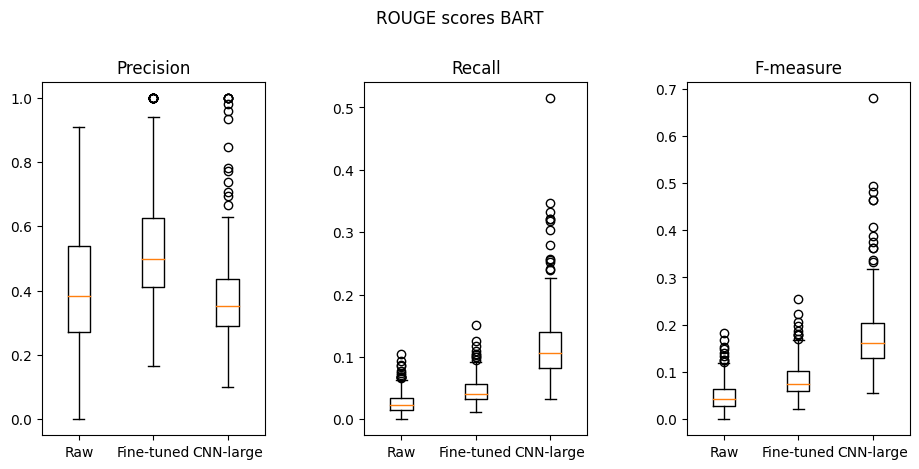

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3)
ax[0].boxplot([rouge_scores_bart_raw['precision'], rouge_scores_bart_tuned['precision'], rouge_scores_bart_cnn['precision']])
ax[0].set_xticklabels(["Raw", "Fine-tuned", "CNN-large"])
ax[0].set_title('Precision')
ax[1].boxplot([rouge_scores_bart_raw['recall'], rouge_scores_bart_tuned['recall'], rouge_scores_bart_cnn['recall']])
ax[1].set_xticklabels(["Raw", "Fine-tuned", "CNN-large"])
ax[1].set_title('Recall')
ax[2].boxplot([rouge_scores_bart_raw['fmeasure'], rouge_scores_bart_tuned['fmeasure'], rouge_scores_bart_cnn['fmeasure']])
ax[2].set_xticklabels(["Raw", "Fine-tuned", "CNN-large"])
ax[2].set_title('F-measure')
fig.suptitle("ROUGE scores BART")
fig.tight_layout(pad=1.5)
fig.set_figwidth(10)

plt.show()

# Pre-trained T5-large model

## No fine-tuning

In [14]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint = "t5-base"
t5_raw_model = T5ForConditionalGeneration.from_pretrained(checkpoint).to(device)
t5_raw_tokenizer = T5Tokenizer.from_pretrained(checkpoint)

In [9]:
rouge_scores_t5_raw = get_rouge_values(t5_raw_model, t5_raw_tokenizer, testing)
rouge_scores_t5_raw.to_csv("rouge_scores_t5_raw.csv")

100%|██████████| 307/307 [02:28<00:00,  2.06it/s]


In [27]:
#i = np.random.randint(len(testing))

#text = testing.iloc[i]["src"]
text = """summarize: Donald Trump, the 45th President of the United States, is a polarizing 
figure who has left an indelible mark on American politics. Known for his 
larger-than-life personality, Trump's presidency was characterized by 
controversial policies, fiery rhetoric, and a penchant for unconventional 
communication through social media.During his time in office, Trump pursued 
an \"America First\" agenda, aiming to prioritize the interests of the United 
States in areas such as trade, immigration, and foreign policy. His 
administration implemented significant tax cuts, deregulation measures, and 
pursued a more assertive stance on international trade agreements.Trump's 
approach to governance often drew both fervent support and vehement opposition. 
Supporters praised his efforts to revitalize the economy, prioritize national 
security, and challenge traditional political norms. Critics, on the other hand, 
raised concerns about his handling of sensitive issues, including immigration, 
climate change, and racial tensions.Beyond policy, Trump's leadership style 
and unfiltered communication drew considerable attention. His prolific use of 
Twitter became a defining characteristic of his presidency, allowing him to 
directly communicate with his base and express his thoughts, often generating 
controversy and media frenzy.Trump's presidency was not without challenges 
and controversies, including investigations into Russian interference in the 
2016 election and subsequent impeachment proceedings. These events further 
deepened the divisions within the country and fueled passionate debates about 
the state of democracy and the role of the presidency.Love him or hate him, 
Donald Trump's impact on American politics and public discourse cannot be denied. 
His presidency left a lasting impression on the nation and continues to shape 
the political landscape as the United States moves forward."""

print(f"Text: {text}")
print()
#print(f"Target: {testing.iloc[i]['tgt']}")
#print()
print(f"Prediction: {predict(t5_raw_model, t5_raw_tokenizer, text)}")

Text: summarize: Donald Trump, the 45th President of the United States, is a polarizing 
figure who has left an indelible mark on American politics. Known for his 
larger-than-life personality, Trump's presidency was characterized by 
controversial policies, fiery rhetoric, and a penchant for unconventional 
communication through social media.During his time in office, Trump pursued 
an "America First" agenda, aiming to prioritize the interests of the United 
States in areas such as trade, immigration, and foreign policy. His 
administration implemented significant tax cuts, deregulation measures, and 
pursued a more assertive stance on international trade agreements.Trump's 
approach to governance often drew both fervent support and vehement opposition. 
Supporters praised his efforts to revitalize the economy, prioritize national 
security, and challenge traditional political norms. Critics, on the other hand, 
raised concerns about his handling of sensitive issues, including immigra

## Fine-tuned to data

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint = "t5-base"
path = ROOT+"t5-base-tuned.pt"
t5_tuned_model = T5ForConditionalGeneration.from_pretrained(checkpoint).to(device)
t5_tuned_model.load_state_dict(torch.load(path))
t5_tuned_tokenizer = T5Tokenizer.from_pretrained(checkpoint)

RuntimeError: ignored

In [ ]:
rouge_scores_t5_tuned = get_rouge_values(t5_tuned_model, t5_tuned_tokenizer, testing)
rouge_scores_t5_tuned.to_csv("rouge_scores_t5_tuned.csv")

In [ ]:
i = np.random.randint(len(testing))

text = testing.iloc[i]["src"]

print(f"Text: {text}")
print()
print(f"Target: {testing.iloc[i]['tgt']}")
print()
print(f"Prediction: {predict(t5_tuned_model, t5_tuned_tokenizer, text)}")

## Fine-tuned to cnn-daily-mail

In [16]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint = "flax-community/t5-base-cnn-dm"
t5_cnn_model = T5ForConditionalGeneration.from_pretrained(checkpoint).to(device)
t5_cnn_tokenizer = T5Tokenizer.from_pretrained('t5-base')

In [13]:
rouge_scores_t5_cnn = get_rouge_values(t5_cnn_model, t5_cnn_tokenizer, testing)
rouge_scores_t5_cnn.to_csv("rouge_scores_t5_cnn.csv")

100%|██████████| 307/307 [02:08<00:00,  2.40it/s]


In [28]:
#i = np.random.randint(len(testing))

#text = testing.iloc[i]["src"]
text = """summarize: Donald Trump, the 45th President of the United States, is a polarizing 
figure who has left an indelible mark on American politics. Known for his 
larger-than-life personality, Trump's presidency was characterized by 
controversial policies, fiery rhetoric, and a penchant for unconventional 
communication through social media.During his time in office, Trump pursued 
an \"America First\" agenda, aiming to prioritize the interests of the United 
States in areas such as trade, immigration, and foreign policy. His 
administration implemented significant tax cuts, deregulation measures, and 
pursued a more assertive stance on international trade agreements.Trump's 
approach to governance often drew both fervent support and vehement opposition. 
Supporters praised his efforts to revitalize the economy, prioritize national 
security, and challenge traditional political norms. Critics, on the other hand, 
raised concerns about his handling of sensitive issues, including immigration, 
climate change, and racial tensions.Beyond policy, Trump's leadership style 
and unfiltered communication drew considerable attention. His prolific use of 
Twitter became a defining characteristic of his presidency, allowing him to 
directly communicate with his base and express his thoughts, often generating 
controversy and media frenzy.Trump's presidency was not without challenges 
and controversies, including investigations into Russian interference in the 
2016 election and subsequent impeachment proceedings. These events further 
deepened the divisions within the country and fueled passionate debates about 
the state of democracy and the role of the presidency.Love him or hate him, 
Donald Trump's impact on American politics and public discourse cannot be denied. 
His presidency left a lasting impression on the nation and continues to shape 
the political landscape as the United States moves forward."""

print(f"Text: {text}")
print()
#print(f"Target: {testing.iloc[i]['tgt']}")
#print()
print(f"Prediction: {predict(t5_cnn_model, t5_cnn_tokenizer, text)}")

Text: summarize: Donald Trump, the 45th President of the United States, is a polarizing 
figure who has left an indelible mark on American politics. Known for his 
larger-than-life personality, Trump's presidency was characterized by 
controversial policies, fiery rhetoric, and a penchant for unconventional 
communication through social media.During his time in office, Trump pursued 
an "America First" agenda, aiming to prioritize the interests of the United 
States in areas such as trade, immigration, and foreign policy. His 
administration implemented significant tax cuts, deregulation measures, and 
pursued a more assertive stance on international trade agreements.Trump's 
approach to governance often drew both fervent support and vehement opposition. 
Supporters praised his efforts to revitalize the economy, prioritize national 
security, and challenge traditional political norms. Critics, on the other hand, 
raised concerns about his handling of sensitive issues, including immigra

## Boxplots

In [15]:
rouge_scores_t5_tuned = pd.read_csv('scores.csv')
rouge_scores_t5_tuned.rename(columns={"f1": "fmeasure"}, inplace=True)
print(rouge_scores_t5_tuned.columns)

Index(['precision', 'recall', 'fmeasure'], dtype='object')


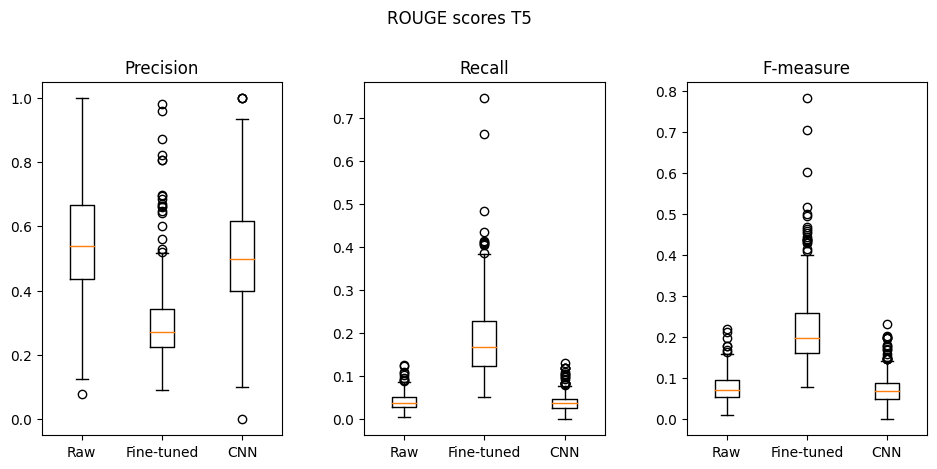

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3)
ax[0].boxplot([rouge_scores_t5_raw['precision'], rouge_scores_t5_tuned['precision'], rouge_scores_t5_cnn['precision']])
ax[0].set_xticklabels(["Raw", "Fine-tuned", "CNN"])
ax[0].set_title('Precision')
ax[1].boxplot([rouge_scores_t5_raw['recall'], rouge_scores_t5_tuned['recall'], rouge_scores_t5_cnn['recall']])
ax[1].set_xticklabels(["Raw", "Fine-tuned", "CNN"])
ax[1].set_title('Recall')
ax[2].boxplot([rouge_scores_t5_raw['fmeasure'], rouge_scores_t5_tuned['fmeasure'], rouge_scores_t5_cnn['fmeasure']])
ax[2].set_xticklabels(["Raw", "Fine-tuned", "CNN"])
ax[2].set_title('F-measure')
fig.suptitle("ROUGE scores T5")
fig.tight_layout(pad=1.5)
fig.set_figwidth(10)

plt.show()

# Testing stuff

In [40]:
len(testing.iloc[8]['tgt'].split(" "))

303

In [44]:
tgt = testing.iloc[8]['tgt']
pred_str = testing.iloc[8]['src']

rs = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True).score(tgt, pred_str)

rs['rougeL'].fmeasure

0.19144981412639406